In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import requests
from io import StringIO
import yfinance as yf
import random
import math

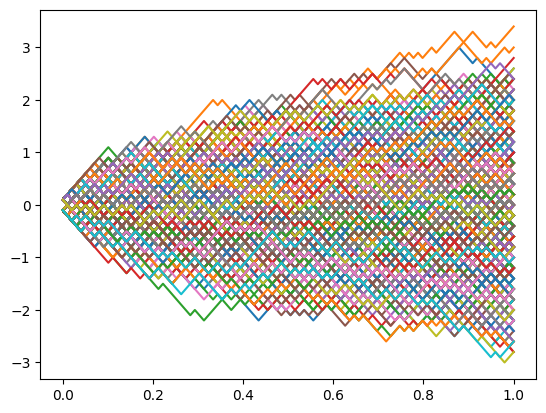

In [2]:
# Fundamentals of Stochastic Modeling 

# 1. Brownian Motion

# Brownian motion (or a Wiener process) is any process which has zero mean, linearly increasing variance as a function of time, and no autocorrelation. Thus it is any process in which the sequence of random variables all follow the same distribution. One common representation is the following

# Two-Point Wiener Processes

def twoPointDist(n):
    x = random.random()
    if x <= 0.5:
        return -1/np.sqrt(n)
    else:
        return 1/np.sqrt(n)
    
def binarySamplePath(n):
    xData172 = np.linspace(0,1,n)
    yData172 = []
    xStep = 0

    for x in xData172:
        dx = twoPointDist(100)
        xStep = xStep + dx
        yData172.append(xStep)

    return xData172, yData172

# Now build a dictionary with the keys labeling the sample path and the value storing the sample path in question. 

brownDct = {}
tIndex = np.linspace(0,1,100)

for n in range(1000):
    wienerPath = binarySamplePath(100)[1]
    brownDct[n+1] = wienerPath

wienerDf = pd.DataFrame(brownDct,tIndex)

wienerDf.plot(legend=False)
plt.show()

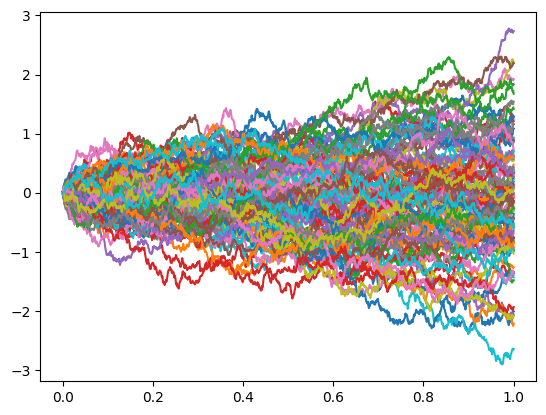

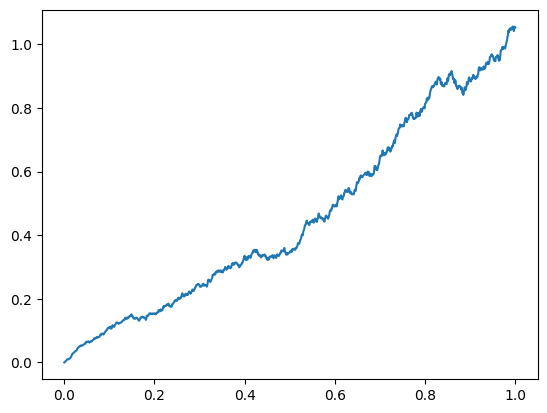

In [ ]:
# This can also be done with a Gaussian distribution, which is more common

def gaussianDist(mu,sigma):
    return np.random.normal(mu,sigma)

def gaussianWienerProc(n,t1):
    dt = t1/n

    tArray = np.linspace(dt,t1,n)
    xArray = [0]
    x = xArray[0]

    for t in tArray:
        x = x + gaussianDist(0,np.sqrt(dt))
        xArray.append(x)
        continue

    tArray = np.concat((np.array([0]),tArray))

    return tArray, xArray


gaussWienerDct = {}

for n in range(100):
    wProc = gaussianWienerProc(1000,1)
    gaussWienerDct[n+1] = wProc[1]

tIndex = wProc[0]
gaussWienerDf = pd.DataFrame(gaussWienerDct,tIndex)

gaussWienerDf.plot(legend=False)
plt.show()

std = gaussWienerDf.var(axis=1)

std.plot()
plt.show()

# Notice that the variance increases linearly with time, as expected.


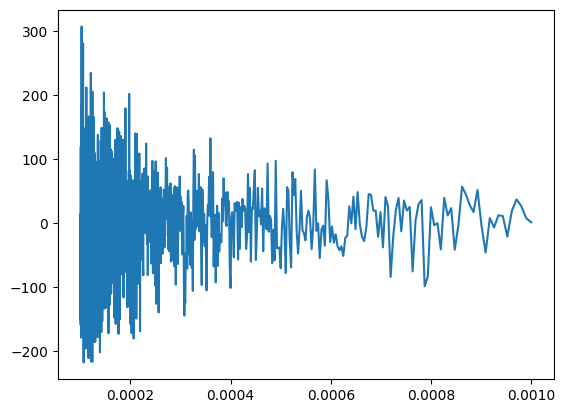

In [32]:
# What happens if we try to calculate the derivative of a Wiener process? This can be done with either the binary wiener process, or the gaussian one. We use the gaussian one for the sake of completeness. Notice the derivative diverges as the partitions become finer and finer. This suggests that the notion of derivative here doesn't necessarily make sense (although it probably does in the path space).

# Now try to evaluate the derivative of this function at t = 0.5 by numerically calculating the derivative for successively smaller areas around 0.5.

deriv174 = []
hVals174 = []

for n in range(1000,10010,10):
    yData174 = gaussianWienerProc(n,1)[1]
    index = math.floor(n/2)
    yDiff = (yData174[index+1]-yData174[index])/(1/n)
    deriv174.append(yDiff)
    hVals174.append(1/n)

plt.plot(hVals174,deriv174)

# Importantly, notice that the derivative diverges in a wild way as one tries to calculate the derivative in terms of GIVEN values, so we need to do something more general.

In [ ]:
# 2. Stochastic Equations

# Now we solve the basic stochastic equations. We use Euler's method. 

# a. Ornstein-Uhlenbeck Process: dx = -a*x*dt + g*dW

# Direct Numerical Integration

def wienerIncrement(s):
    return np.random.normal(0,np.sqrt(s))

def xStep(s,f,g,dt):
    return f*dt + g*wienerIncrement(s)

def wienerDerivFn(gamma,g,n):

    t1 = 1
    dt = t1/n

    tArray = np.linspace(dt,t1,n)
    xArray = [1]
    xNow = xArray[0]

    for t in tArray:
        f = -gamma*xNow
        dx = xStep(dt,f,g,dt)
        xNow = xNow + dx
        xArray.append(xNow)
        continue

    tArray = np.concatenate((np.array([0]),tArray))

    return tArray, xArray

# Numerical Representation of Analytical Solution

def wienerIntegral(t,n,dt,gamma):
    tArrayHold = np.linspace(0,t,n)
    sum = 0
    for tp in tArrayHold:
        sum = sum + dt*np.exp(gamma*(tp-t))*wienerIncrement(tp)
    return sum

def wienerIntFn(gamma,g,n):
    t1 = 1
    dt = t1/n

    tArray = np.linspace(dt,t1,n)
    xArray1 = [1]
    x0 = xArray1[0]

    for t in tArray:
        x = x0*np.exp(-gamma*t) + g*wienerIntegral(t,n,dt,gamma) 
        xArray1.append(x)

    tArray = np.concatenate((np.array([0]),tArray))
    
    return tArray, xArray1

wienerIntDct = {}
wienerDerivDct = {}

for j in range(100):
    wienerIntProc = wienerIntFn(1,1,3*10**2)
    wienerDerivProc = wienerDerivFn(1,1,3*10**2)
    wienerIntDct[j+1] = wienerIntProc[1]
    wienerDerivDct[j+1] = wienerDerivProc[1]

tIntArray = wienerIntProc[0]
tDerivArray = wienerDerivProc[0]

wienerIntDf = pd.DataFrame(wienerIntDct,index=tIntArray)
wienerDerivDf = pd.DataFrame(wienerDerivDct,index=tDerivArray)

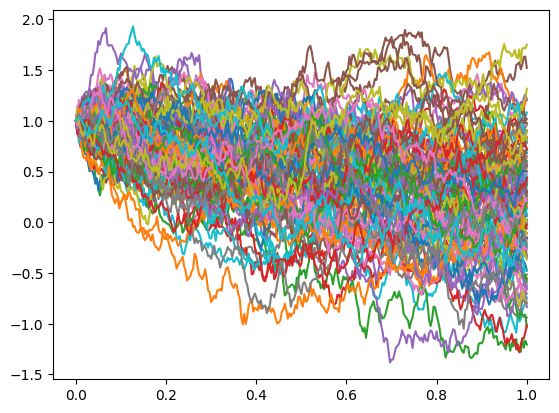

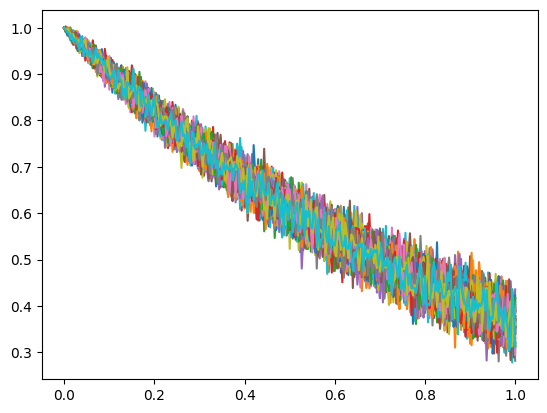

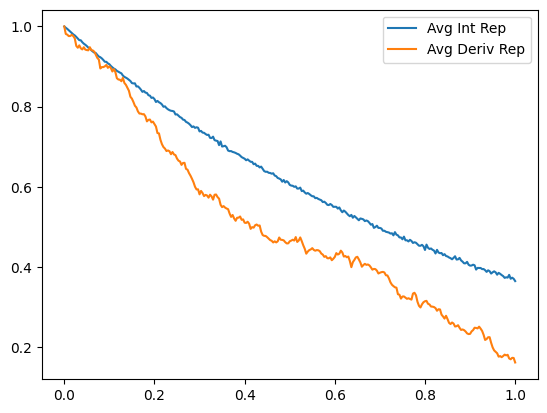

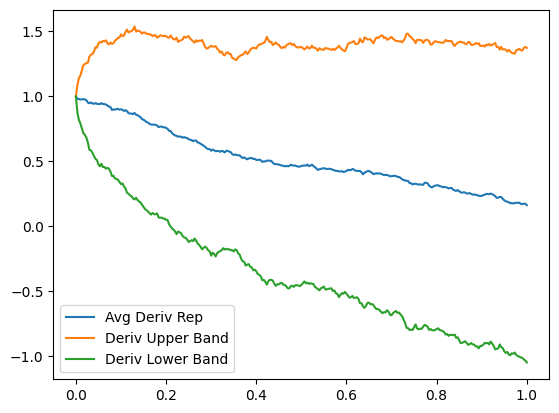

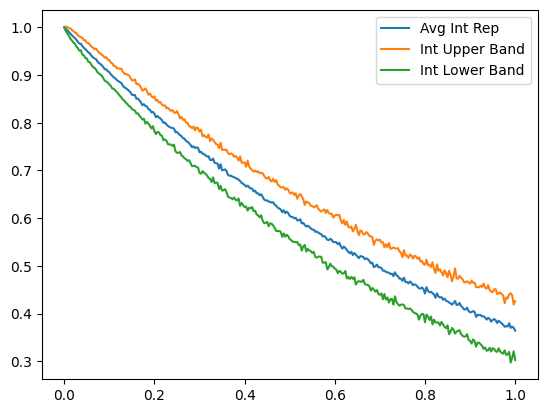

In [55]:
# Plots of our solutions

# Numerical Integration 
for j in range(1,101):
    wienerDerivDf[j].plot()

plt.show()

# Numerical Representation of Exact Solution
for j in range(1,101):
    wienerIntDf[j].plot()

plt.show()

wienerDerivAvg = wienerDerivDf.mean(axis=1)
wienerIntAvg = wienerIntDf.mean(axis=1)

wienerDerivVar = wienerDerivDf.std(axis=1)
wienerIntVar = wienerIntDf.std(axis=1)

wienerAvg = pd.concat([wienerIntAvg,wienerDerivAvg], axis=1)
wienerVar = pd.concat([wienerIntVar,wienerDerivVar], axis=1)

wienerAvg = wienerAvg.rename(columns={0 : "Avg Int Rep", 1 : "Avg Deriv Rep"})
wienerVar = wienerVar.rename(columns={0 : "Var Int Rep", 1 : "Var Deriv Rep"})

wienerAvg.plot()
plt.show()

wienerStats = wienerAvg.join(wienerVar)
wienerStats["Deriv Upper Band"] = wienerStats["Avg Deriv Rep"] + 2*wienerStats["Var Deriv Rep"]
wienerStats["Deriv Lower Band"] = wienerStats["Avg Deriv Rep"] - 2*wienerStats["Var Deriv Rep"]
wienerStats["Int Upper Band"] = wienerStats["Avg Int Rep"] + 2*wienerStats["Var Int Rep"]
wienerStats["Int Lower Band"] = wienerStats["Avg Int Rep"] - 2*wienerStats["Var Int Rep"]

wienerStats[["Avg Deriv Rep","Deriv Upper Band","Deriv Lower Band"]].plot()
plt.show()

wienerStats[["Avg Int Rep","Int Upper Band","Int Lower Band"]].plot()
plt.show()



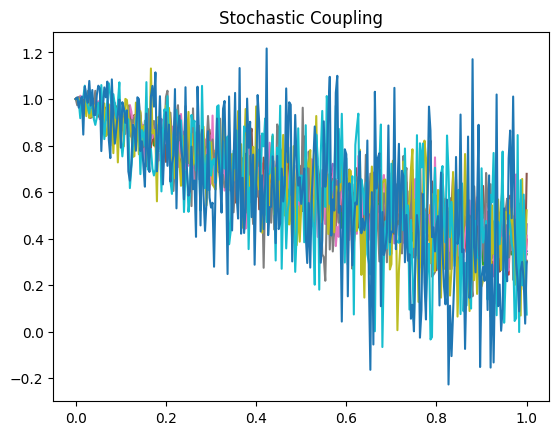

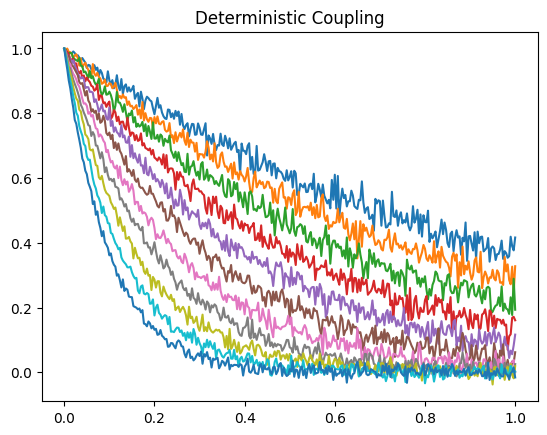

In [ ]:
# Lets look at variations in f,g. We'll stick to the analytical solution

paramArray = 10**np.linspace(0,1,11)
gPaths = {}
gammaPaths = {}
k = 1

for s in paramArray:
    gPath = wienerIntFn(1,s,3*10**2)
    gammaPath = wienerIntFn(s,1,3*10**2)
    gPaths[k] = gPath[1]
    gammaPaths[k] = gammaPath[1]
    k = k+1
    continue

tArray = gPath[0]

gPathsDf = pd.DataFrame(gPaths,tArray)
gammaPathsDf = pd.DataFrame(gammaPaths,tArray)

gPathsDf.plot(legend=False,title="Stochastic Coupling")
plt.show()

gammaPathsDf.plot(legend=False,title="Deterministic Coupling")
plt.show()

# These results make sense; turning up the stochastic coupling means that the random variations become dominant in the long-time dynamics. On the other hand, turning up the coupling for the deterministic part yields a dominant overall exponential suppression factor. Obviously this mutes the statistical variation as well. 


In [ ]:
# b. General linear stochastic equation